# 02D. Stability

### Mingyang Lu

### 12/21/2023

## Stability of steady states

Consider $\frac{dX}{dt} = g- kX$. We first plot the first and second terms of the derivative function separately.

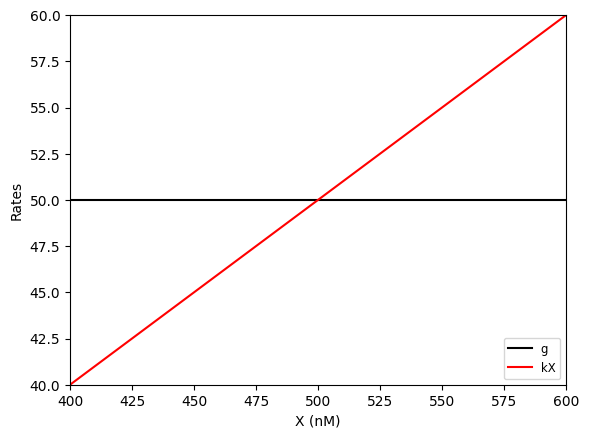

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
g = 50
k = 0.1

# All X values to be sampled
X_all = np.arange(400, 601, 1)

# Plot the first term g
plt.plot(X_all, np.full_like(X_all, g), color='black', label='g')
# Add the second term kX
plt.plot(X_all, k * X_all, color='red', label='kX')

# Set axis labels and limits
plt.xlabel('X (nM)')
plt.ylabel('Rates')
plt.xlim(400, 600)
plt.ylim(40, 60)

# Add legend
plt.legend(loc='lower right', fontsize='small')

# Show the plot
plt.show()

The intersect of the two curves represents the steady state. It's a stable steady state, when $\frac{df(X)}{dX} < 0$.

Now, let us consider the circuit with a self-inhibiting gene, whose dynamics is governed by

$$\frac{dX}{dt} = g(X) - kX$$

,where $g(X) = g_0 + g_1 H^{inh}(X)$

$H^{inh}(X)$ is the inhibitory Hill function with expression

$$H^{inh}(X) \equiv \frac{1}{1+(X/X_{th})^{n_X}}$$

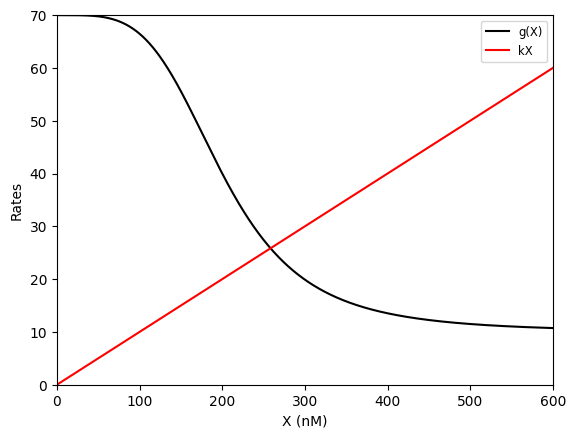

In [2]:
# Define parameters
g_0 = 10
g_1 = 60
k = 0.1
X_th = 200
n = 4

# Inhibitory Hill function
# X_th: Hill threshold, n: Hill coefficient
def hill_inh(X, X_th, n):
    a = (X / X_th) ** n
    return 1 / (1 + a)

# All X values to be sampled
X_all = np.arange(0, 601, 1)

# Plot the first term g(X)
plt.plot(X_all, g_0 + g_1 * hill_inh(X_all, X_th, n), color='black', label='g(X)')

# Plot the second term kX
plt.plot(X_all, k * X_all, color='red', label='kX')

# Set axis labels and limits
plt.xlabel('X (nM)')
plt.ylabel('Rates')
plt.xlim(0, 600)
plt.ylim(0, 70)

# Add legend
plt.legend(loc='upper right', fontsize='small')

# Show the plot
plt.show()

Let us also compute $\frac{df(X)}{dX}$. Note that we use vector operations for high efficiency.

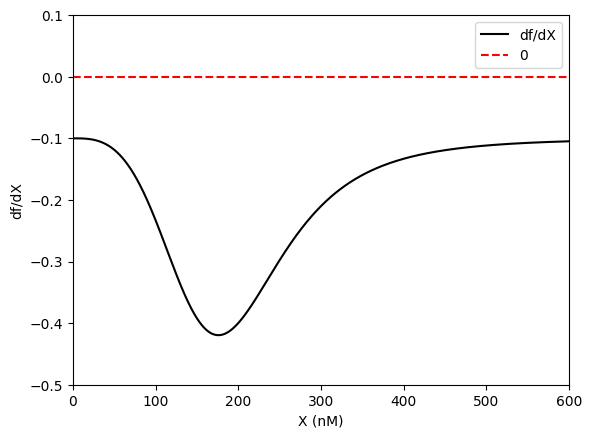

In [3]:
# Calculate f(X)
def f_1g_self_inh(X, g0, g1, X_th, n, k):
    return g0 + g1 * hill_inh(X, X_th, n) - k * X

def cal_dfdx(X_all, dt, derivs, **kwargs): # Calculate df(X)/dt
    # X_all is a vector of all X values to be sampled
    # derivs takes the name of the derivatives function
    # **kwargs to take model parameters

    # f(X) for all X values in a vector
    f_all = derivs(X_all, **kwargs)
    # f(X+dx), achieved by shifting the vector by one to the left
    f_all_shift_by_plus_one = np.concatenate([f_all[1:], [np.nan]])
    # f(X-dx), achieved by shifting the vector by one to the right
    f_all_shift_by_minus_one = np.concatenate([[np.nan], f_all[:-1]])
     # df/dX = (f(X+dx) - f(X-dx))/2/dt
    return (f_all_shift_by_plus_one - f_all_shift_by_minus_one) / (2 * dt)

# All X values to be sampled
X_all = np.arange(0, 600.1, 0.1)

# Calculate df(X)/dt
dt = 0.1
dfdX = cal_dfdx(X_all, dt, f_1g_self_inh, 
                g0 = 10, g1 = 60, X_th = 200, n = 4, k = 0.1)

# Plot df(X)/dX
plt.plot(X_all, dfdX, color='black', label='df/dX')
plt.axhline(0, linestyle='--', color='red', label='0')

# Set axis labels and limits
plt.xlabel('X (nM)')
plt.ylabel('df/dX')
plt.xlim(0, 600)
plt.ylim(-0.5, 0.1)

# Show the plot
plt.legend()
plt.show()

In this case, $\frac{df(X)}{dX} < 0$ at the steady state X (around 250 nM). Thus, the steady state is stable.

## Multi-stability

The third example is the circuit with a self-activating gene, whose dynamics is governed by

$$\frac{dX}{dt} = g(X) - kX$$

,where $g(X) = g_0 + g_1 H^{ex}(X)$

$H^{ex}(X)$ is the excitatory Hill function with expression

$$H^{ex}(X) \equiv \frac{(X/X_{th})^{n_X}}{1+(X/X_{th})^{n_X}}$$

Again, we plot $g(X)$ and $kX$. In the plot below, we vary the value of $k$ and fix the rest of the parameters. 

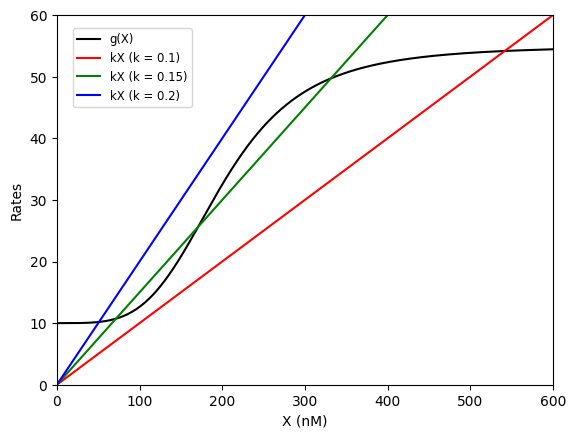

In [4]:
# Define parameters
g0 = 10
g1 = 45
X0 = 200
n = 4

# Excitatory Hill function
# X_th: Hill threshold, n: Hill coefficient
def hill_ex(X, X_th, n):
    a = (X / X_th) ** n
    return a / (1 + a)

# All X values to be sampled
X_all = np.arange(0, 601, 1)

# Plot the first term g(X)
plt.plot(X_all, g0 + g1 * hill_ex(X_all, X_th, n), color='black', label='g(X)')

# Plot the second term kX for different values of k
plt.plot(X_all, 0.1 * X_all, color='red', label='kX (k = 0.1)')
plt.plot(X_all, 0.15 * X_all, color='green', label='kX (k = 0.15)')
plt.plot(X_all, 0.2 * X_all, color='blue', label='kX (k = 0.2)')

# Set axis labels and limits
plt.xlabel('X (nM)')
plt.ylabel('Rates')
plt.xlim(0, 600)
plt.ylim(0, 60)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize='small')

# Show the plot
plt.show()

When $k = 0.1$ or $k = 0.2$, the circuit has only one steady state. 

When $k = 0.15$, the circuit has three steady states. Two of these steady states are stable, and the other one is unstable. This is called bistability. We can simulate the ODE with different initial conditions to see that time trajectories converge to two steady states.

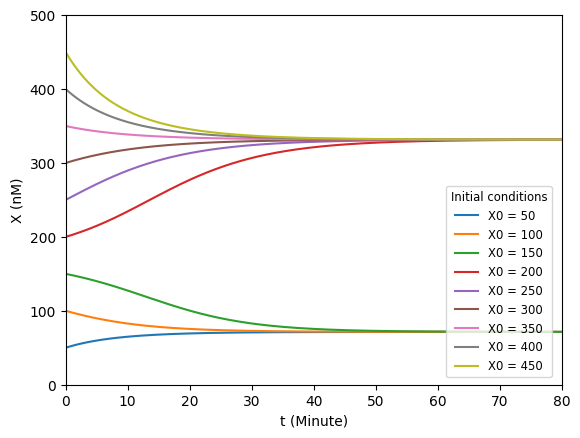

In [5]:
from scipy.integrate import solve_ivp

# Define parameters
parameters = {'g0': 10, 'g1': 45, 'X_th': 200, 'n': 4, 'k': 0.15}

# Modified derivative function for scipy ode solver
# Pay attention to the usage of implicit line continuation below
def dy_deSolve_1g_self_act(t, y):
    g0, g1, X_th, n, k = parameters['g0'], parameters['g1'
    ], parameters['X_th'], parameters['n'], parameters['k']
    return [g0 + g1 * hill_ex(y, X_th, n) - k * y]

# Excitatory Hill function
# X_th: Hill threshold, n: Hill coefficient
def hill_ex(X, X_th, n):
    a = (X / X_th) ** n
    return a / (1 + a)

# Time sequence for which output is needed
t_all = np.arange(0, 80.1, 0.1)

# All initial conditions, each leads to a different simulation
X0_all = np.arange(50, 451, 50)

# Initialize plotting
plt.figure()
plt.xlabel('t (Minute)')
plt.ylabel('X (nM)')
plt.xlim(0, 80)
plt.ylim(0, 500)

# ODE simulation per initial condition
legend_text = []
for X in X0_all:
    results = solve_ivp(dy_deSolve_1g_self_act, [0, 80], [X], t_eval=t_all, method='RK45',
                        rtol=1e-6, atol=1e-8)
    plt.plot(results.t, results.y[0], label=f'X0 = {X}')

    legend_text.append(f'X0 = {X}')

# Add legend
plt.legend(title='Initial conditions', loc='lower right', bbox_to_anchor=(0.98, 0.02), 
           borderaxespad=0., title_fontsize='small', fontsize='small')

# Show the plot
plt.show()

Again, we can also learn the stability of steady states from the $\frac{df(X)}{dX}$ curve.

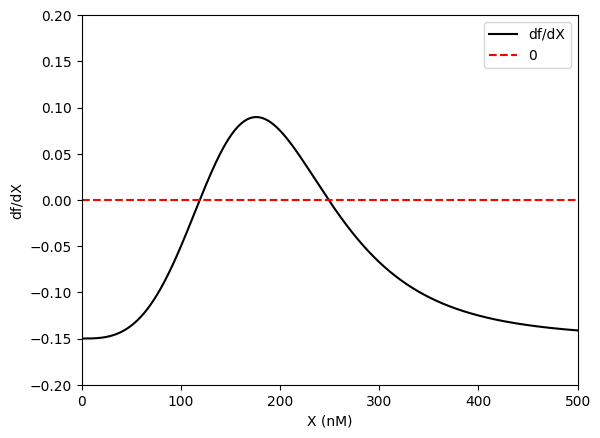

In [6]:
# Define f(X)
def f_1g_self_act(X, g0, g1, X_th, n, k):
    return g0 + g1 * hill_ex(X, X_th, n) - k * X

# All X values to be sampled
X_all = np.arange(0, 500.1, 0.1)

# Calculate df(X)/dt
dt = 0.1
dfdX = cal_dfdx(X_all, dt, f_1g_self_act, 
                g0 = 10, g1 = 45, X_th = 200, n = 4, k = 0.15)

# Plot df(X)/dX
plt.plot(X_all, dfdX, color='black', label='df/dX')
plt.axhline(0, linestyle='--', color='red', label='0')

# Set axis labels and limits
plt.xlabel('X (nM)')
plt.ylabel('df/dX')
plt.xlim(0, 500)
plt.ylim(-0.2, 0.2)

# Show the plot
plt.legend()
plt.show()

## Effective potential

For an ODE $ \frac{dX}{dt} = f(X)$, the potential function can be defined as

$$ U(X) = -\int_{X_0}^X f(x)dx + U(X_0) $$

We set $U(X_0 = 0) = 0$. A common numerical method to integrate a function is by the trapezoidal rule. We got

$$ U(X+\Delta x) = U(X) - \frac{f(X) + f(X+ \Delta x)}{2}\Delta x $$

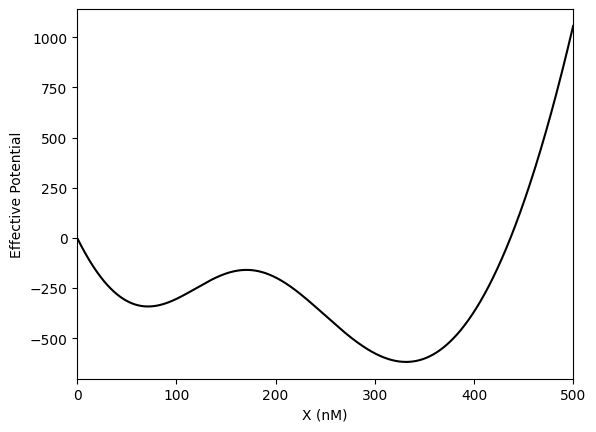

In [7]:
# Integrate f(X) with the trapezoidal rule
def cal_int(Xmin, Xmax, dX, f, **kwargs):
    # Xmin: minimum X values
    # Xmax: maximum X values
    # dX: X step size
    # **kwargs to pass all model parameters
    X_all = np.arange(Xmin, Xmax + 0.1, 0.1)
    nX = len(X_all)
    
    # Initialize a vector of potential U
    U_all = np.zeros(nX)

    for i in range(nX - 1):
        X = X_all[i]
        U_all[i + 1] = U_all[i] - (f(X, **kwargs) + f(X + dX, **kwargs)) / 2 * dX

    return np.column_stack((X_all, U_all))

# Calculate effective potential
results_1 = cal_int(Xmin=0, Xmax=500, dX=0.1, f=f_1g_self_act, 
                    g0=10, g1=45, X_th=200, n=4, k=0.15)

# Plot effective potential
plt.plot(results_1[:, 0], results_1[:, 1], color='black', label='_')
plt.xlabel('X (nM)')
plt.ylabel('Effective Potential')
plt.xlim(0, 500)
plt.show()

Same numerical integration, but this time with vectorization.

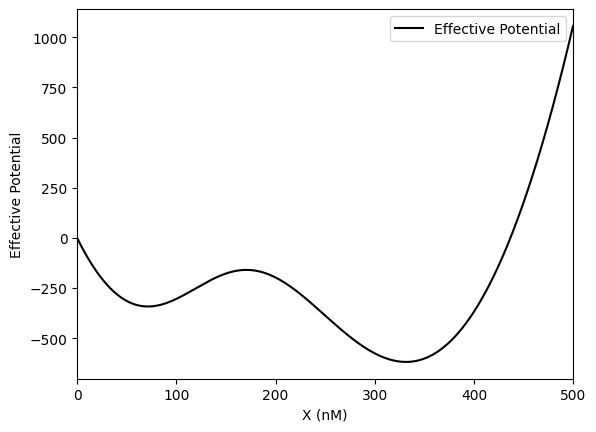

In [8]:
# Integrate f(X) with the vectorized approach
def cal_int_vector(Xmin, Xmax, dX, f, **kwargs):
    # Xmin: minimum X values
    # Xmax: maximum X values
    # dX: X step size
    # f: function name
    # *args: arguments to pass all model parameters to f(X, *args)
    X_all = np.arange(Xmin, Xmax + dX, dX)
    f_all = f(X_all, **kwargs)  # generate all f(X)
    # another array containing f(X+dx), except for the last point
    f_all_shift_by_plus_one = np.concatenate([f_all[1:], [np.nan]])  
    f_all = (f_all + f_all_shift_by_plus_one) * dX / 2  # each integrated part
    U_all = -np.cumsum(f_all)
    return np.column_stack((X_all, U_all))  # perform cumulative sum

# Calculate effective potential with vectorized approach
results_2 = cal_int_vector(Xmin=0, Xmax=500, dX=0.1, f=f_1g_self_act, 
                           g0=10, g1=45, X_th=200, n=4, k=0.15)

# Plot effective potential
plt.plot(results_2[:, 0], results_2[:, 1], color='black', label='Effective Potential')
plt.xlabel('X (nM)')
plt.ylabel('Effective Potential')
plt.xlim(0, 500)
plt.legend()
plt.show()

In [9]:
# Benchmarking
%timeit cal_int(0, 500, 0.1, f_1g_self_act, g0 = 10, g1 = 45, X_th = 200, n = 4, k = 0.15)
%timeit cal_int_vector(0, 500, 0.1, f_1g_self_act, g0 = 10, g1 = 45, X_th = 200, n = 4, k = 0.15)

12.3 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
183 µs ± 3.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Finally, we show the effective potential for $k = 0.2 \text{Minute}^{-1}$.

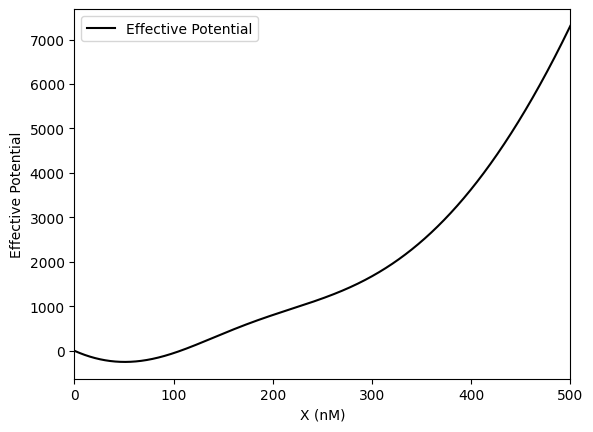

In [10]:
results_3 = cal_int_vector(Xmin=0, Xmax=500, dX=0.1, f=f_1g_self_act, 
                           g0=10, g1=45, X_th=200, n=4, k=0.2)

# Plot effective potential
plt.plot(results_3[:, 0], results_3[:, 1], color='black', label='Effective Potential')
plt.xlabel('X (nM)')
plt.ylabel('Effective Potential')
plt.xlim(0, 500)
plt.legend()
plt.show()

And the effective potential for $k = 0.1 \text{Minute}^{-1}$.

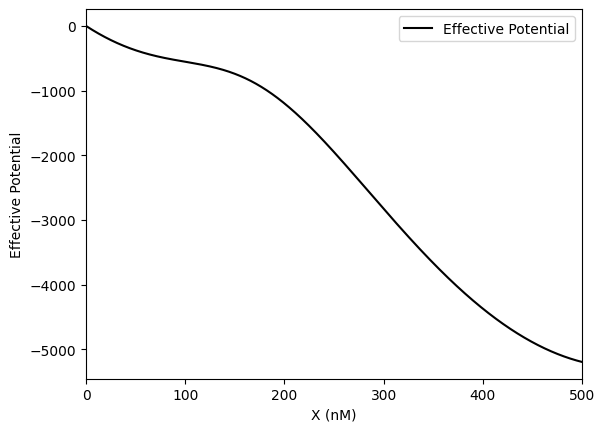

In [11]:
results_4 = cal_int_vector(Xmin=0, Xmax=500, dX=0.1, f=f_1g_self_act, 
                           g0=10, g1=45, X_th=200, n=4, k=0.1)

# Plot effective potential
plt.plot(results_4[:, 0], results_4[:, 1], color='black', label='Effective Potential')
plt.xlabel('X (nM)')
plt.ylabel('Effective Potential')
plt.xlim(0, 500)
plt.legend()
plt.show()